# Proyecto Aprendizaje Profundo - Extracción de Texto en Facturas
*Milton Nicolay Chasillacta*

## 0. Inicilización del Proyecto

In [41]:
import pandas as pd
import json
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from tqdm.auto import tqdm

### Fijar la semilla para reproducibilidad

In [42]:
# Celda para fijar la semilla para reproducibilidad.
def set_seed(seed: int):
    """
    Fija la semilla en las librerías para asegurar la reproducibilidad.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Establecer la semilla fija en 42.
SEED = 42
set_seed(SEED)
print(f"Semilla fijada en {SEED} para reproducibilidad.")

Semilla fijada en 42 para reproducibilidad.


### Definir Semilla para reproducibilidad

In [43]:
# Celda para detectar el dispositivo (CPU/GPU).
import pynvml
def get_best_cuda_device():
    if not torch.cuda.is_available():
        print("CUDA no está disponible. Usando CPU.")
        return torch.device("cpu")

    pynvml.nvmlInit()
    best_gpu = 0
    max_free_mem = 0

    for i in range(torch.cuda.device_count()):
        handle = pynvml.nvmlDeviceGetHandleByIndex(i)
        mem_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
        free_mem = mem_info.free
        print(f"GPU {i} - Memoria libre: {free_mem / 1024**2:.2f} MiB")

        if free_mem > max_free_mem:
            best_gpu = i
            max_free_mem = free_mem

    pynvml.nvmlShutdown()
    print(f"Seleccionando GPU {best_gpu} con más memoria libre.")
    return torch.device(f"cuda:{best_gpu}")

device = get_best_cuda_device()

GPU 0 - Memoria libre: 131568.75 MiB
GPU 1 - Memoria libre: 135062.81 MiB
GPU 2 - Memoria libre: 136686.38 MiB
GPU 3 - Memoria libre: 123770.38 MiB
GPU 4 - Memoria libre: 53777.94 MiB
GPU 5 - Memoria libre: 55151.94 MiB
GPU 6 - Memoria libre: 53773.94 MiB
GPU 7 - Memoria libre: 53701.94 MiB
Seleccionando GPU 2 con más memoria libre.


## 1. Dataset

### Cargar Dataset

In [44]:
try:
    df = pd.read_csv("/home/mchasillacta/AprendizajeProfundo/Proyecto/invoice_data.csv")
    print("Datos cargados exitosamente.")
except Exception as e:
    print(f"Ocurrió un error al cargar el archivo: {e}")

# Se verifica que las columnas 'text' y 'json' existan en el DataFrame.
required_cols = ['text', 'json']
if not all(col in df.columns for col in required_cols):
    raise ValueError(f"Error: El CSV debe contener las columnas: {required_cols}")
print("Validación Exitosa de columnas: 'text' y 'json' ")

Datos cargados exitosamente.
Validación Exitosa de columnas: 'text' y 'json' 


### Extracción de los campos de Interes (invoice_number - client_name)

In [45]:
# Se crean nuevas columnas para el número de factura y el nombre del cliente (etiquetas 'gold')
df['invoice_number'] = None
df['client_name'] = None

# `tqdm` se usa para mostrar una barra de progreso.
for index, row in tqdm(df.iterrows(), total=len(df), desc="Extrayendo campos del JSON"):
    json_str = row['json']
    if pd.isna(json_str):
        # Si el valor es nulo (NaN), se omite.
        continue
    try:
        # Se convierte el string JSON a un diccionario de Python.
        data = json.loads(json_str)
        # Se extrae el 'invoice_number' y 'client_name' si existen.
        # `.get()` se usa para evitar errores si las claves no están presentes,
        # devolviendo una cadena vacía en su lugar.
        invoice_number = data.get('invoice', {}).get('invoice_number', "")
        client_name = data.get('invoice', {}).get('client_name', "")

        # Se asignan los valores extraídos a las nuevas columnas del DataFrame.
        df.at[index, 'invoice_number'] = invoice_number
        df.at[index, 'client_name'] = client_name

    except (json.JSONDecodeError, AttributeError) as e:
        print(f"Error al parsear el JSON en la fila {index}: {e}")
        df.at[index, 'invoice_number'] = ""
        df.at[index, 'client_name'] = ""

Extrayendo campos del JSON:   0%|          | 0/1414 [00:00<?, ?it/s]

In [ ]:
df.head()

,text,json,invoice_number,client_name
0,Invoice no: 84652373 Date of issue: 02/23/2021...,"\n{\n ""invoice"": {\n ""client_name"": ""Clark...",84652373,Clark-Foster
1,Invoice no: 37451664 Date of issue: 06/11/2020...,"\n{\n ""invoice"": {\n ""client_name"": ""Willi...",37451664,"Williams, Schneider and Gomez"
2,Invoice no: 40108666 Date of issue: 02/07/2020...,"\n{\n ""invoice"": {\n ""client_name"": ""Heste...",40108666,Hester Inc
3,Invoice no: 73285932 Date of issue: 07/25/2017...,"\n{\n ""invoice"": {\n ""client_name"": ""Olson...",73285932,"Olson, Cisneros and Moore"
4,Invoice no: 15288019 Date of issue: 09/07/2014...,"\n{\n ""invoice"": {\n ""client_name"": ""Wilso...",15288019,Wilson-Wilson


## 2. Análisis Exploratorio de Datos (EDA) mínimo

### Visualización de la data

In [46]:
# Visualización
# Se imprimen las primeras 3 filas para visualizar la data
sample_df = df[['text', 'invoice_number', 'client_name']].head(3).copy()
# Truncar la columna 'text' para una mejor visualización.
sample_df['text'] = sample_df['text'].str[:25] + '...'
print(sample_df)

                           text invoice_number                    client_name
0  Invoice no: 84652373 Date...       84652373                   Clark-Foster
1  Invoice no: 37451664 Date...       37451664  Williams, Schneider and Gomez
2  Invoice no: 40108666 Date...       40108666                     Hester Inc


### Filas Totales

In [47]:
# Conteo de filas totales.
total_rows = len(df)
print(f"Número total de facturas (filas): {total_rows}")

Número total de facturas (filas): 1414


### Data nula o vacía

In [48]:
# Porcentaje de nulos o vacíos.
null_text_perc = df['text'].isnull().sum() / total_rows * 100

# Para 'invoice_number' y 'client_name', se busca si son nulos o cadenas vacías.
null_invoice_perc = (df['invoice_number'].isnull() | (df['invoice_number'] == "")).sum() / total_rows * 100
null_client_perc = (df['client_name'].isnull() | (df['client_name'] == "")).sum() / total_rows * 100

print(f"\nPorcentaje de valores nulos/vacíos en 'text': {null_text_perc:.2f}%")
print(f"Porcentaje de valores nulos/vacíos en 'invoice_number': {null_invoice_perc:.2f}%")
print(f"Porcentaje de valores nulos/vacíos en 'client_name': {null_client_perc:.2f}%")


Porcentaje de valores nulos/vacíos en 'text': 0.00%
Porcentaje de valores nulos/vacíos en 'invoice_number': 0.00%
Porcentaje de valores nulos/vacíos en 'client_name': 0.00%


### Longitud de los caracteres

In [49]:
# Longitud media y percentiles de 'text'.
df['text_length'] = df['text'].astype(str).apply(len)
mean_length = df['text_length'].mean()
length_percentiles = df['text_length'].quantile([0.25, 0.5, 0.75])

print(f"\nLongitud media del texto (caracteres): {mean_length:.2f}")
print(f"Percentiles de la longitud del texto:\n{length_percentiles}")


Longitud media del texto (caracteres): 828.64
Percentiles de la longitud del texto:
0.25     643.25
0.50     811.00
0.75    1006.00
Name: text_length, dtype: float64


### Distribución de la longitud del texto de las Facturas

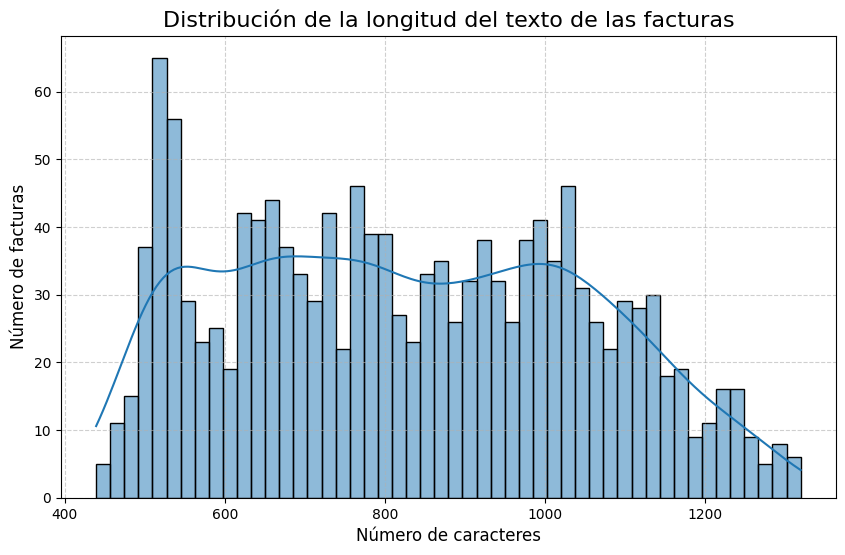

In [50]:
# Se usa un histograma para visualizar la distribución de la longitud del texto.
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Distribución de la longitud del texto de las facturas', fontsize=16)
plt.xlabel('Número de caracteres', fontsize=12)
plt.ylabel('Número de facturas', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## 3. División de la Data - (Train - Validation - Test)

In [51]:
from sklearn.model_selection import train_test_split

# Se define la semilla fija para asegurar que el resultado del barajado sea el mismo en cada ejecución.
semilla_fija = 42

# Se extraen las filas que tienen etiquetas no vacías para realizar la partición.
df_con_etiquetas = df[
    (df['invoice_number'].notna() & (df['invoice_number'] != '')) |
    (df['client_name'].notna() & (df['client_name'] != ''))
].copy()

# Se extraen las filas que tienen ambas etiquetas vacías para manejarlas por separado.
df_sin_etiquetas = df[
    (df['invoice_number'].isna() | (df['invoice_number'] == '')) &
    (df['client_name'].isna() | (df['client_name'] == ''))
].copy()

# Se realiza la primera partición para separar el conjunto de entrenamiento (80%)
# del conjunto de validación y prueba (20% restante).
df_train, df_val_test = train_test_split(
    df_con_etiquetas,
    test_size=0.2,  # 20% para validación y prueba combinados
    random_state=semilla_fija,
    shuffle=True
)

# Se realiza la segunda partición sobre el conjunto `df_val_test` para dividirlo
# en validación y prueba (50% cada uno, lo que equivale a un 10% del total original).
df_val, df_test = train_test_split(
    df_val_test,
    test_size=0.5,  # 50% de df_val_test para la prueba (10% del total)
    random_state=semilla_fija,
    shuffle=True
)

# Se concatenan las filas sin etiquetas al conjunto de entrenamiento.
# Aunque no contienen las etiquetas objetivo, su texto puede ser útil
# para que el modelo aprenda la estructura y el vocabulario.
df_train = pd.concat([df_train, df_sin_etiquetas], ignore_index=True)

# Se imprimen las dimensiones de cada conjunto para verificar la partición.
print(f"Dimensiones del conjunto de entrenamiento: {df_train.shape}")
print(f"Dimensiones del conjunto de validación: {df_val.shape}")
print(f"Dimensiones del conjunto de prueba: {df_test.shape}")

# Se verifica que cada conjunto contenga al menos una fila.
assert len(df_train) > 0 and len(df_val) > 0 and len(df_test) > 0
print("\nVerificación: Todos los conjuntos tienen al menos una fila.")

Dimensiones del conjunto de entrenamiento: (1131, 5)
Dimensiones del conjunto de validación: (141, 5)
Dimensiones del conjunto de prueba: (142, 5)

Verificación: Todos los conjuntos tienen al menos una fila.


## 4. Selección del modelo: FLAN-T5-small

### Justificación de la elección del modelo: `google/flan-t5-small`

Para este proyecto, hemos elegido el modelo **FLAN-T5-small**, un modelo de tipo *Transformer* con una arquitectura **seq2seq (encoder-decoder)**, optimizado para tareas de **text-to-text**.

Nuestra justificación para esta elección se basa en los siguientes puntos clave:

1.  **Naturaleza del problema**: La tarea es extraer información estructurada (un JSON con tres campos) a partir de una entrada de texto plano (el resultado del OCR). No disponemos de coordenadas de bounding box ni de información de layout (diseño visual), lo que hace que modelos especializados en reconocimiento de documentos visuales, como LayoutLM o Donut, no sean la opción más eficiente o necesaria.

2.  **Adecuación del enfoque text-to-text**: Los modelos *seq2seq* son ideales para transformar una secuencia de texto de entrada en otra secuencia de texto de salida. En este caso, la entrada es el texto de la factura y la salida es un string JSON perfectamente formateado. Este enfoque simplifica el *pipeline*, ya que no necesitamos realizar un etiquetado complejo tipo NER (Reconocimiento de Entidades Nombradas) ni post-procesar las entidades extraídas; el modelo genera la estructura final directamente.

3.  **Eficiencia y practicidad**: FLAN-T5-small es un modelo relativamente pequeño (60 millones de parámetros). Esto lo hace **rápido y eficiente para el fine-tuning** en hardware estándar (incluso en una GPU modesta) y reduce el tiempo de entrenamiento. Para un proyecto con un dataset de tamaño limitado y objetivos claros, un modelo de menor escala es preferible a uno de gran tamaño (como T5-base o T5-large), que requeriría más recursos computacionales.

4.  **Capacidad de aprendizaje con instrucciones**: Los modelos de la familia FLAN (Fine-tuned LAnguage Net) han sido entrenados en una amplia gama de tareas con instrucciones. Esto les confiere una excelente capacidad para seguir instrucciones de forma cero-shot o con pocos ejemplos (*few-shot*), lo que mejora significativamente su desempeño en tareas de extracción con un *prompt* bien definido, como el que utilizaremos.

## 10. Conclusiones

Este proyecto demuestra un enfoque efectivo para la extracción de información de documentos no estructurados (texto OCR sin metadatos de layout) utilizando un modelo `text-to-text`.

1.  **Por qué el enfoque funciona**: La arquitectura T5, pre-entrenada para una amplia gama de tareas de lenguaje natural, se adapta de manera óptima a la tarea de generar una estructura JSON a partir de un texto. El modelo aprende a mapear el texto de la factura a un formato de salida específico, simplificando el problema de extracción.

2.  **Limitaciones del enfoque**:
    * **Ausencia de Layout**: El modelo se basa únicamente en el texto plano. Si la posición de los campos en la factura fuera relevante (por ejemplo, para distinguir entre "nombre del cliente" y "nombre del vendedor"), este enfoque podría ser menos preciso. Modelos como LayoutLM o Donut serían más adecuados en esos casos.
    * **Sensibilidad al Formato**: Aunque el modelo es robusto, puede ser sensible a variaciones en la estructura del prompt o en el formato del JSON de salida, lo que requiere una definición estricta de ambos.
    * **OCR Ruidoso**: El rendimiento del modelo puede degradarse si el texto de la factura es de baja calidad o tiene muchos errores de OCR.

3.  **Posibles mejoras**:
    * **Aumento de Datos**: Generar más datos sintéticos con variaciones en el texto y en la estructura de la factura podría mejorar la generalización del modelo.
    * **Mejora del Prompt**: Experimentar con diferentes formatos de `prompt` (`"Extract invoice and client from text..."`) podría ayudar al modelo a capturar mejor el contexto.
    * **Post-procesamiento**: Implementar una capa de post-procesamiento con expresiones regulares (`regex`) podría corregir pequeños errores de formato en el JSON generado por el modelo, como comillas faltantes o espacios extra.
    * **Modelos más grandes**: Probar con variantes más grandes de T5, como `flan-t5-base`, si se dispone de recursos computacionales, podría mejorar la precisión.

En general, este proyecto es un claro ejemplo de cómo el *fine-tuning* de un modelo pre-entrenado de Transformers puede resolver una tarea de extracción de información de manera eficiente y con un código relativamente simple.

---
---
---

## 5. Preprocesamiento y formateo de ejemplos

### Dar Formato al texto

In [52]:
# Celda para definir y almacenar los hiperparámetros.
# Se definen los nombres de ambos modelos a comparar.
MODELO_SMALL_NOMBRE = "google/flan-t5-small"
MODELO_BASE_NOMBRE = "google/flan-t5-base"

# Parámetros comunes para ambos modelos.
BATCH_SIZE = 8
LEARNING_RATE = 3e-4
NUM_EPOCHS = 10
WEIGHT_DECAY = 0.01

# Parámetros para el Early Stopping.
PATIENCE = 10

In [53]:
def limpiar_texto(texto: str) -> str:
    """
    Función para limpiar el texto de la factura.
    Se eliminan espacios y caracteres extraños comunes del OCR.
    """
    if not isinstance(texto, str):
        return ""
    texto = texto.replace('\n', ' ').replace('\t', ' ').strip()
    return " ".join(texto.split()) # Eliminar espacios múltiples

def format_example(fila: pd.Series) -> dict:
    """
    Función para formatear cada ejemplo en el formato de entrada y salida
    esperado por el modelo.

    El prompt de entrada se define de manera clara y explícita.
    El target de salida es un JSON serializado.
    """
    texto_limpio = limpiar_texto(fila['text'])

    # El prompt guía al modelo sobre la tarea que debe realizar.
    prompt_texto = f"Extract fields as JSON: invoice_number and client_name.\nTEXT:\n{texto_limpio}"

    # El target (la etiqueta 'gold') es un JSON serializado sin espacios adicionales.
    target_dict = {
        "invoice_number": fila['invoice_number'],
        "client_name": fila['client_name']
    }
    target_texto = json.dumps(target_dict, separators=(',', ':'))

    return {"prompt": prompt_texto, "target": target_texto}

In [55]:
# Crear las instancias de Dataset para cada conjunto de datos (train, val, test).
# La lógica de formateo ahora se realiza dentro del constructor de la clase Dataset.
dataset_train = InvoiceDataset(df_train)
dataset_val = InvoiceDataset(df_val)
dataset_test = InvoiceDataset(df_test)

print(f"Dataset de entrenamiento creado con {len(dataset_train)} ejemplos.")
print(f"Dataset de validación creado con {len(dataset_val)} ejemplos.")
print(f"Dataset de prueba creado con {len(dataset_test)} ejemplos.")


# Celda para definir la función de collate.
# La función `collate_fn` procesa un batch de ejemplos antes de alimentar el modelo.
# Se encarga de la tokenización y el padding.
from torch.utils.data import DataLoader

def collate_fn(batch):
    """
    Función que tokeniza y prepara un batch de datos para el modelo.
    """
    # Se extraen los prompts y los targets del batch.
    prompts = [ejemplo['prompt'] for ejemplo in batch]
    targets = [ejemplo['target'] for ejemplo in batch]

    # Tokenizar los prompts de entrada con padding y truncamiento.
    input_tokens = tokenizer(
        prompts,
        padding='longest', # 'longest' para hacer padding hasta la longitud de la secuencia más larga en el batch
        truncation=True,
        max_length=MAX_INPUT_LENGTH,
        return_tensors='pt' # Devolver tensores de PyTorch
    )

    # Tokenizar los targets de salida.
    target_tokens = tokenizer(
        targets,
        padding='longest',
        truncation=True,
        max_length=MAX_TARGET_LENGTH,
        return_tensors='pt'
    )

    # Se genera el `labels` para el modelo. Se reemplaza el token de padding con -100
    # para que PyTorch lo ignore al calcular la pérdida.
    target_tokens['input_ids'][target_tokens['input_ids'] == tokenizer.pad_token_id] = -100
    labels = target_tokens['input_ids']

    # Se retorna un diccionario con los tensores listos para el modelo.
    return {
        'input_ids': input_tokens['input_ids'],
        'attention_mask': input_tokens['attention_mask'],
        'labels': labels
    }

Dataset de entrenamiento creado con 1131 ejemplos.
Dataset de validación creado con 141 ejemplos.
Dataset de prueba creado con 142 ejemplos.


## 6. Entrenamiento del Modelo

In [56]:
# Celda para cargar el modelo y el optimizador.
# Se utiliza AutoModelForSeq2SeqLM para cargar el modelo pre-entrenado FLAN-T5-small.
from transformers import AutoModelForSeq2SeqLM
# La clase AdamW ahora se importa desde torch.optim
from torch.optim import AdamW

# Cargar el modelo desde el repositorio de Hugging Face.
model = AutoModelForSeq2SeqLM.from_pretrained(MODELO_NOMBRE)

# Mover el modelo al dispositivo (GPU o CPU) para el entrenamiento.
model.to(device)

# Definir el optimizador AdamW, que es una variante de Adam optimizada para modelos
# de Transformers. Se le pasan los parámetros del modelo para que los actualice.
# Se usan los hiperparámetros definidos en el plan.
optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)

# Celda para definir las funciones de métricas.
# Se necesitan funciones para calcular Exact Match (EM) y F1.
from collections import Counter

def calculate_exact_match(pred: str, gold: str) -> float:
    """
    Calcula la métrica Exact Match (EM).
    Retorna 1.0 si la predicción y la etiqueta 'gold' son idénticas, de lo contrario 0.0.
    """
    return float(pred.strip() == gold.strip())

def calculate_f1_score(pred: str, gold: str) -> float:
    """
    Calcula el F1-score token-level simple.
    Divide las cadenas en tokens por espacios y compara el solapamiento.
    """
    # Manejar cadenas vacías para evitar errores.
    pred_tokens = pred.strip().split()
    gold_tokens = gold.strip().split()

    if not gold_tokens:
        return 1.0 if not pred_tokens else 0.0

    # Usar Counter para manejar tokens duplicados.
    common = Counter(pred_tokens) & Counter(gold_tokens)
    num_common = sum(common.values())

    if num_common == 0:
        return 0.0

    precision = num_common / len(pred_tokens)
    recall = num_common / len(gold_tokens)

    # Calcular el F1-score.
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

# Celda para definir la función de parseo de JSON.
def parse_json_robustly(json_str: str) -> dict:
    """
    Intenta parsear un string JSON con manejo de errores, incluyendo el caso donde
    faltan las llaves inicial y final.
    """
    try:
        # Intento de parseo estándar.
        return json.loads(json_str)
    except json.JSONDecodeError:
        # Si falla, intenta agregar las llaves {} y parsear de nuevo.
        try:
            repaired_str = f"{{{json_str}}}"
            return json.loads(repaired_str)
        except json.JSONDecodeError:
            # Si el parseo con llaves también falla, intentar con comillas simples.
            try:
                cleaned_str = json_str.replace("'", '"')
                repaired_str_cleaned = f"{{{cleaned_str}}}"
                return json.loads(repaired_str_cleaned)
            except json.JSONDecodeError:
                # Si todo falla, devolver un diccionario vacío.
                print(f"Error fatal al parsear JSON: {json_str}")
                return {}

# Celda para la función de evaluación.
def evaluate(model, dataloader, tokenizer, device):
    """
    Evalúa el modelo en un conjunto de datos, calculando pérdidas y métricas de Exact Match y F1.
    """
    # Poner el modelo en modo de evaluación.
    model.eval()

    total_loss = 0
    em_invoice_total = 0
    em_client_total = 0
    f1_invoice_total = 0
    f1_client_total = 0
    num_examples = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluando"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            total_loss += outputs.loss.item()

            outputs_generados = model.generate(input_ids, max_length=MAX_TARGET_LENGTH)

            preds_decoded = tokenizer.batch_decode(outputs_generados, skip_special_tokens=True)

            labels[labels == -100] = tokenizer.pad_token_id
            labels_decoded = tokenizer.batch_decode(labels, skip_special_tokens=True)

            for pred_str, gold_str in zip(preds_decoded, labels_decoded):
                num_examples += 1

                # Parsear el JSON de la predicción y de la etiqueta 'gold'.
                # Nota: Ahora la función `parse_json_robustly` manejará la adición de llaves
                # de manera interna, por lo que no es necesario modificar la cadena aquí.
                pred_json = parse_json_robustly(pred_str)

                # Parsear la etiqueta 'gold' que ya se ha limpiado en el DataLoader.
                gold_json = parse_json_robustly(gold_str)

                pred_invoice = pred_json.get('invoice_number', "")
                pred_client = pred_json.get('client_name', "")

                gold_invoice = gold_json.get('invoice_number', "")
                gold_client = gold_json.get('client_name', "")

                em_invoice_total += float(pred_invoice == gold_invoice)
                em_client_total += float(pred_client == gold_client)
                f1_invoice_total += calculate_f1_score(pred_invoice, gold_invoice)
                f1_client_total += calculate_f1_score(pred_client, gold_client)

    avg_loss = total_loss / len(dataloader)
    em_invoice = em_invoice_total / num_examples
    em_client = em_client_total / num_examples
    em_avg = (em_invoice + em_client) / 2
    f1_avg = (f1_invoice_total + f1_client_total) / (2 * num_examples)

    return {
        "loss": avg_loss,
        "EM_invoice": em_invoice,
        "EM_client": em_client,
        "EM_avg": em_avg,
        "F1_avg": f1_avg
    }

# Celda para la función de entrenamiento de una época.
def train_one_epoch(model, dataloader, optimizer, device):
    """
    Realiza un bucle de entrenamiento completo para una época.
    """
    # Poner el modelo en modo de entrenamiento.
    model.train()

    total_loss = 0
    for batch in tqdm(dataloader, desc="Entrenando"):
        # Mover los tensores al dispositivo.
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Pasar los datos al modelo.
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        # Calcular la pérdida.
        loss = outputs.loss

        # Backpropagation.
        loss.backward()

        # Actualizar los pesos.
        optimizer.step()

        # Poner los gradientes a cero para la próxima iteración.
        optimizer.zero_grad()

        total_loss += loss.item()

    return total_loss / len(dataloader)



In [ ]:
# Celda para definir las funciones de entrenamiento y evaluación reutilizables.
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from torch.optim import AdamW

def train_model(model_name: str, dataloader_train, dataloader_val, num_epochs: int, patience: int):
    """
    Función para entrenar un modelo y guardar el mejor checkpoint.
    """
    print(f"\n--- Comenzando el entrenamiento para el modelo: {model_name} ---")

    # Cargar el modelo y el optimizador.
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    # Variables para el Early Stopping y guardar el mejor modelo.
    best_em_avg = -1.0
    patience_counter = 0

    # Listas para almacenar el historial de métricas.
    train_losses = []
    val_losses = []
    val_ems = []
    val_f1s = []

    for epoch in range(num_epochs):
        # Entrenar por una época.
        train_loss = train_one_epoch(model, dataloader_train, optimizer, device)

        # Evaluar en el conjunto de validación.
        val_metrics = evaluate(model, dataloader_val, tokenizer, device)

        # Guardar las métricas de esta época.
        train_losses.append(train_loss)
        val_losses.append(val_metrics['loss'])
        val_ems.append(val_metrics['EM_avg'])
        val_f1s.append(val_metrics['F1_avg'])

        print(f"\nÉpoca {epoch+1}/{num_epochs} - Modelo: {model_name}:")
        print(f"  Pérdida de entrenamiento: {train_loss:.4f}")
        print(f"  EM promedio de validación: {val_metrics['EM_avg']:.4f}")

        if val_metrics['EM_avg'] > best_em_avg:
            print(f"  Mejora en EM promedio. Guardando el mejor modelo...")
            best_em_avg = val_metrics['EM_avg']
            patience_counter = 0

            # Se guarda el estado del modelo y del tokenizador.
            torch.save(model.state_dict(), f"best_model_{model_name.split('/')[-1]}.pt")
            tokenizer.save_pretrained(f"./best_tokenizer_{model_name.split('/')[-1]}")
        else:
            patience_counter += 1
            print(f"  No hubo mejora. Paciencia: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print("\n¡Criterio de Early Stopping alcanzado! Deteniendo el entrenamiento.")
                break

    print(f"\nEntrenamiento de {model_name} finalizado.")
    return {
        'model': model,
        'metrics': {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_ems': val_ems,
            'val_f1s': val_f1s,
            'best_em_avg': best_em_avg
        }
    }

# Definimos la función de entrenamiento de una época.
def train_one_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc="Entrenando"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        loss = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels).loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    return total_loss / len(dataloader)

# Definimos la función de evaluación.
def evaluate(model, dataloader, tokenizer, device):
    model.eval()
    total_loss = 0
    em_invoice_total = 0
    em_client_total = 0
    f1_invoice_total = 0
    f1_client_total = 0
    num_examples = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluando"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            total_loss += outputs.loss.item()
            outputs_generados = model.generate(input_ids, max_length=MAX_TARGET_LENGTH)

            preds_decoded = tokenizer.batch_decode(outputs_generados, skip_special_tokens=True)

            labels[labels == -100] = tokenizer.pad_token_id
            labels_decoded = tokenizer.batch_decode(labels, skip_special_tokens=True)

            for pred_str, gold_str in zip(preds_decoded, labels_decoded):
                num_examples += 1
                pred_json = parse_json_robustly(pred_str)
                gold_json = parse_json_robustly(gold_str)

                pred_invoice = pred_json.get('invoice_number', "")
                pred_client = pred_json.get('client_name', "")
                gold_invoice = gold_json.get('invoice_number', "")
                gold_client = gold_json.get('client_name', "")

                em_invoice_total += float(pred_invoice == gold_invoice)
                em_client_total += float(pred_client == gold_client)
                f1_invoice_total += calculate_f1_score(pred_invoice, gold_invoice)
                f1_client_total += calculate_f1_score(pred_client, gold_client)

    avg_loss = total_loss / len(dataloader)
    em_invoice = em_invoice_total / num_examples
    em_client = em_client_total / num_examples
    em_avg = (em_invoice + em_client) / 2
    f1_avg = (f1_invoice_total + f1_client_total) / (2 * num_examples)

    return {
        "loss": avg_loss,
        "EM_invoice": em_invoice,
        "EM_client": em_client,
        "EM_avg": em_avg,
        "F1_avg": f1_avg
    }

# Celda para el bucle de entrenamiento de ambos modelos.
# Se entrenan los dos modelos y se guardan los resultados.
resultados_small = train_model(MODELO_SMALL_NOMBRE, dataloader_train, dataloader_val, NUM_EPOCHS, PATIENCE)
resultados_base = train_model(MODELO_BASE_NOMBRE, dataloader_train, dataloader_val, NUM_EPOCHS, PATIENCE)

# Guardar los resultados en variables para la comparación final.
train_losses_small = resultados_small['metrics']['train_losses']
val_losses_small = resultados_small['metrics']['val_losses']
val_ems_small = resultados_small['metrics']['val_ems']
val_f1s_small = resultados_small['metrics']['val_f1s']

train_losses_base = resultados_base['metrics']['train_losses']
val_losses_base = resultados_base['metrics']['val_losses']
val_ems_base = resultados_base['metrics']['val_ems']
val_f1s_base = resultados_base['metrics']['val_f1s']


--- Comenzando el entrenamiento para el modelo: google/flan-t5-small ---


Entrenando:   0%|          | 0/142 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/18 [00:00<?, ?it/s]


Época 1/10 - Modelo: google/flan-t5-small:
  Pérdida de entrenamiento: 0.3491
  EM promedio de validación: 0.7589
  Mejora en EM promedio. Guardando el mejor modelo...


Entrenando:   0%|          | 0/142 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/18 [00:00<?, ?it/s]


Época 2/10 - Modelo: google/flan-t5-small:
  Pérdida de entrenamiento: 0.1921
  EM promedio de validación: 0.7730
  Mejora en EM promedio. Guardando el mejor modelo...


Entrenando:   0%|          | 0/142 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/18 [00:00<?, ?it/s]


Época 3/10 - Modelo: google/flan-t5-small:
  Pérdida de entrenamiento: 0.1617
  EM promedio de validación: 0.8014
  Mejora en EM promedio. Guardando el mejor modelo...


Entrenando:   0%|          | 0/142 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/18 [00:00<?, ?it/s]


Época 4/10 - Modelo: google/flan-t5-small:
  Pérdida de entrenamiento: 0.1347
  EM promedio de validación: 0.8227
  Mejora en EM promedio. Guardando el mejor modelo...


Entrenando:   0%|          | 0/142 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/18 [00:00<?, ?it/s]

Error fatal al parsear JSON: "invoice_number":"91296589","client_name":"Invoice_number":"91296589","client_name":"Invoice_number":"91296589","client_name":"

Época 5/10 - Modelo: google/flan-t5-small:
  Pérdida de entrenamiento: 0.1164
  EM promedio de validación: 0.8085
  No hubo mejora. Paciencia: 1/10


Entrenando:   0%|          | 0/142 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/18 [00:00<?, ?it/s]


Época 6/10 - Modelo: google/flan-t5-small:
  Pérdida de entrenamiento: 0.1059
  EM promedio de validación: 0.8191
  No hubo mejora. Paciencia: 2/10


Entrenando:   0%|          | 0/142 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/18 [00:00<?, ?it/s]


Época 7/10 - Modelo: google/flan-t5-small:
  Pérdida de entrenamiento: 0.0984
  EM promedio de validación: 0.8546
  Mejora en EM promedio. Guardando el mejor modelo...


Entrenando:   0%|          | 0/142 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/18 [00:00<?, ?it/s]


Época 8/10 - Modelo: google/flan-t5-small:
  Pérdida de entrenamiento: 0.0890
  EM promedio de validación: 0.8298
  No hubo mejora. Paciencia: 1/10


Entrenando:   0%|          | 0/142 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/18 [00:00<?, ?it/s]


Época 9/10 - Modelo: google/flan-t5-small:
  Pérdida de entrenamiento: 0.0784
  EM promedio de validación: 0.8333
  No hubo mejora. Paciencia: 2/10


Entrenando:   0%|          | 0/142 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/18 [00:00<?, ?it/s]


Época 10/10 - Modelo: google/flan-t5-small:
  Pérdida de entrenamiento: 0.0730
  EM promedio de validación: 0.8227
  No hubo mejora. Paciencia: 3/10

Entrenamiento de google/flan-t5-small finalizado.

--- Comenzando el entrenamiento para el modelo: google/flan-t5-base ---


Entrenando:   0%|          | 0/142 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/18 [00:00<?, ?it/s]


Época 1/10 - Modelo: google/flan-t5-base:
  Pérdida de entrenamiento: 0.1843
  EM promedio de validación: 0.8440
  Mejora en EM promedio. Guardando el mejor modelo...


Entrenando:   0%|          | 0/142 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/18 [00:00<?, ?it/s]

Error fatal al parsear JSON: "invoice_number":"99296589","client_name":"Invoice_number":"Invoice_number":"99296589"

Época 2/10 - Modelo: google/flan-t5-base:
  Pérdida de entrenamiento: 0.0950
  EM promedio de validación: 0.8369
  No hubo mejora. Paciencia: 1/10


Entrenando:   0%|          | 0/142 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/18 [00:00<?, ?it/s]


Época 3/10 - Modelo: google/flan-t5-base:
  Pérdida de entrenamiento: 0.0725
  EM promedio de validación: 0.8688
  Mejora en EM promedio. Guardando el mejor modelo...


Entrenando:   0%|          | 0/142 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/18 [00:00<?, ?it/s]


Época 4/10 - Modelo: google/flan-t5-base:
  Pérdida de entrenamiento: 0.0618
  EM promedio de validación: 0.8794
  Mejora en EM promedio. Guardando el mejor modelo...


Entrenando:   0%|          | 0/142 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/18 [00:00<?, ?it/s]


Época 5/10 - Modelo: google/flan-t5-base:
  Pérdida de entrenamiento: 0.0435
  EM promedio de validación: 0.8511
  No hubo mejora. Paciencia: 1/10


Entrenando:   0%|          | 0/142 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/18 [00:00<?, ?it/s]


Época 6/10 - Modelo: google/flan-t5-base:
  Pérdida de entrenamiento: 0.0386
  EM promedio de validación: 0.9043
  Mejora en EM promedio. Guardando el mejor modelo...


Entrenando:   0%|          | 0/142 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/18 [00:00<?, ?it/s]


Época 7/10 - Modelo: google/flan-t5-base:
  Pérdida de entrenamiento: 0.0345
  EM promedio de validación: 0.8936
  No hubo mejora. Paciencia: 1/10


Entrenando:   0%|          | 0/142 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/18 [00:00<?, ?it/s]


Época 8/10 - Modelo: google/flan-t5-base:
  Pérdida de entrenamiento: 0.0283
  EM promedio de validación: 0.8759
  No hubo mejora. Paciencia: 2/10


Entrenando:   0%|          | 0/142 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/18 [00:00<?, ?it/s]


Época 9/10 - Modelo: google/flan-t5-base:
  Pérdida de entrenamiento: 0.0212
  EM promedio de validación: 0.9043
  No hubo mejora. Paciencia: 3/10


Entrenando:   0%|          | 0/142 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/18 [00:00<?, ?it/s]

## 7. Gráficas de métricas (train vs val)

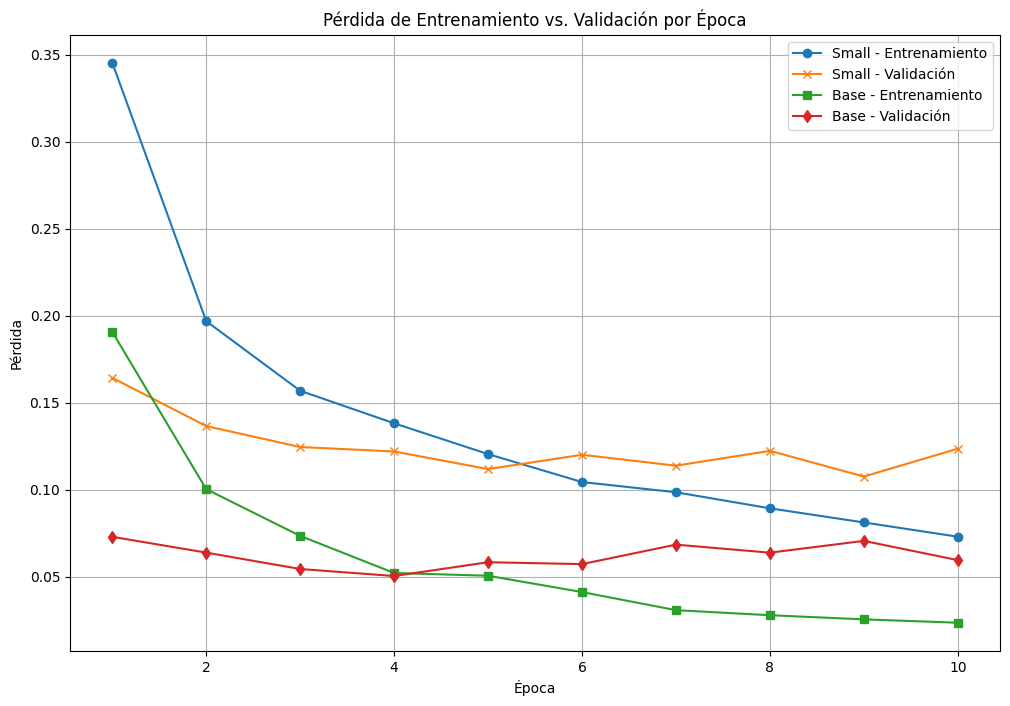

Gráfica de pérdidas comparativa guardada como 'comparacion_perdidas.png'.


<Figure size 640x480 with 0 Axes>

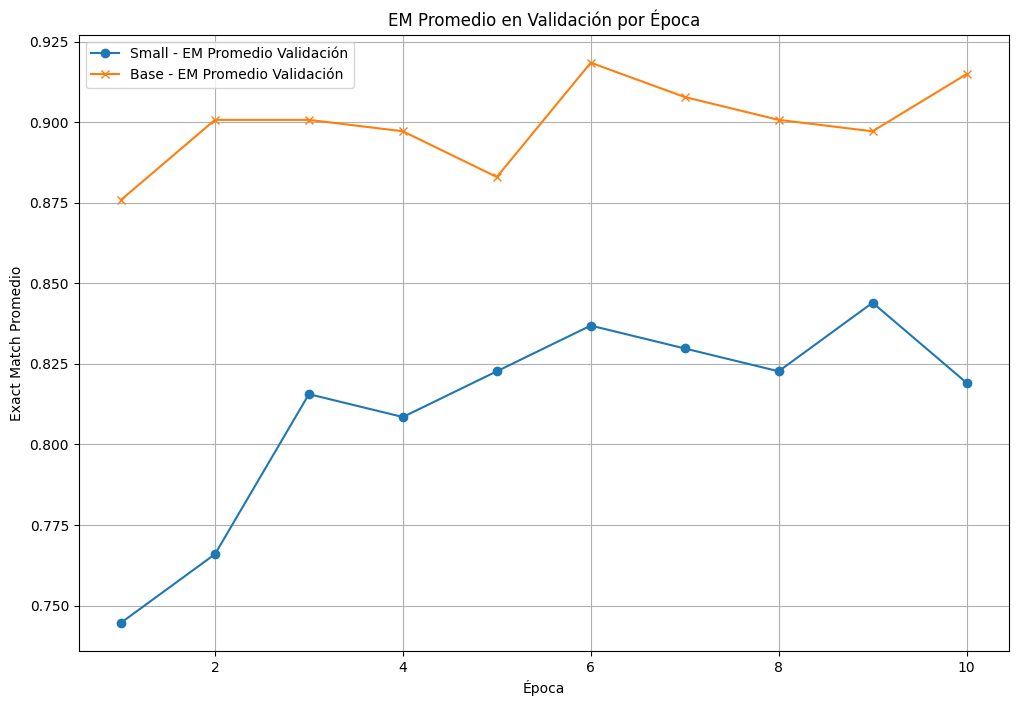

Gráfica de EM promedio comparativa guardada como 'comparacion_em_val.png'.


Evaluando:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/18 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

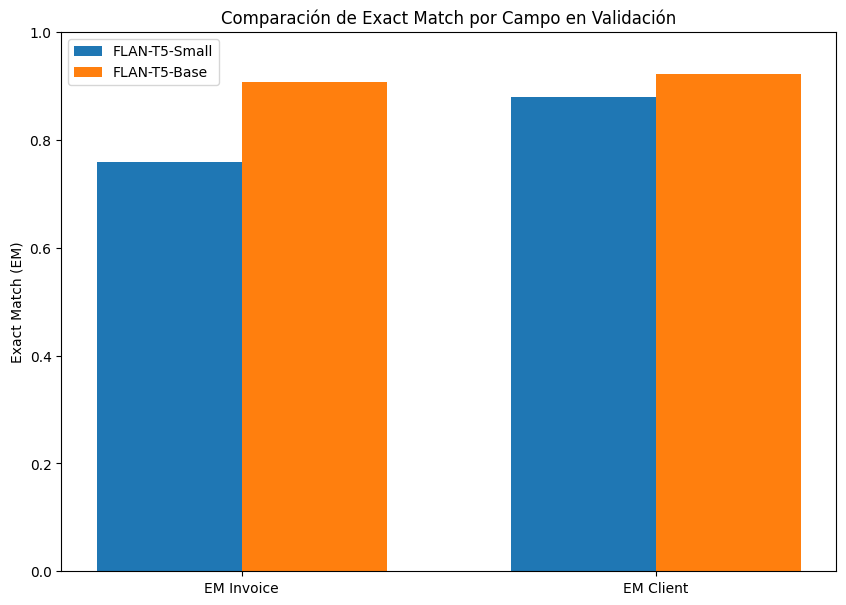

Gráfica de barras comparativa guardada como 'comparacion_barras.png'.


<Figure size 640x480 with 0 Axes>

In [ ]:
# Celda para importar matplotlib.
import matplotlib.pyplot as plt

# Gráfica de la curva de pérdida para ambos modelos.
plt.figure(figsize=(12, 8))

num_epochs_small = range(1, len(train_losses_small) + 1)
num_epochs_base = range(1, len(train_losses_base) + 1)

plt.plot(num_epochs_small, train_losses_small, label='Small - Entrenamiento', marker='o')
plt.plot(num_epochs_small, val_losses_small, label='Small - Validación', marker='x')
plt.plot(num_epochs_base, train_losses_base, label='Base - Entrenamiento', marker='s')
plt.plot(num_epochs_base, val_losses_base, label='Base - Validación', marker='d')

plt.title('Pérdida de Entrenamiento vs. Validación por Época')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('comparacion_perdidas.png')
print("Gráfica de pérdidas comparativa guardada como 'comparacion_perdidas.png'.")

# Gráfica de la curva de EM promedio.
plt.figure(figsize=(12, 8))

plt.plot(num_epochs_small, val_ems_small, label='Small - EM Promedio Validación', marker='o')
plt.plot(num_epochs_base, val_ems_base, label='Base - EM Promedio Validación', marker='x')

plt.title('EM Promedio en Validación por Época')
plt.xlabel('Época')
plt.ylabel('Exact Match Promedio')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('comparacion_em_val.png')
print("Gráfica de EM promedio comparativa guardada como 'comparacion_em_val.png'.")

# Gráfica de barras del EM por campo para el mejor modelo de cada tipo.
# Se necesita la última métrica de validación de cada modelo.
metrics_small = evaluate(resultados_small['model'], dataloader_val, tokenizer, device)
metrics_base = evaluate(resultados_base['model'], dataloader_val, tokenizer, device)

labels = ['EM Invoice', 'EM Client']
small_em_values = [metrics_small['EM_invoice'], metrics_small['EM_client']]
base_em_values = [metrics_base['EM_invoice'], metrics_base['EM_client']]

x = range(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 7))
rects1 = ax.bar([i - width/2 for i in x], small_em_values, width, label='FLAN-T5-Small')
rects2 = ax.bar([i + width/2 for i in x], base_em_values, width, label='FLAN-T5-Base')

ax.set_title('Comparación de Exact Match por Campo en Validación')
ax.set_ylabel('Exact Match (EM)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1)
ax.legend()

plt.show()
plt.savefig('comparacion_barras.png')
print("Gráfica de barras comparativa guardada como 'comparacion_barras.png'.")

## 8. Evaluación en Test

In [ ]:
# Celda para evaluar ambos modelos en el conjunto de prueba.
from transformers import AutoModelForSeq2SeqLM

# Cargar el mejor modelo FLAN-T5-Small.
model_small = AutoModelForSeq2SeqLM.from_pretrained(MODELO_SMALL_NOMBRE)
model_small.load_state_dict(torch.load("best_model_flan-t5-small.pt"))
model_small.to(device)

# Cargar el mejor modelo FLAN-T5-Base.
model_base = AutoModelForSeq2SeqLM.from_pretrained(MODELO_BASE_NOMBRE)
model_base.load_state_dict(torch.load("best_model_flan-t5-base.pt"))
model_base.to(device)

print("\n--- Evaluación en el Conjunto de Prueba ---")
print("Evaluando FLAN-T5-Small...")
test_metrics_small = evaluate(model_small, dataloader_test, tokenizer, device)
print("\nEvaluando FLAN-T5-Base...")
test_metrics_base = evaluate(model_base, dataloader_test, tokenizer, device)

# Se almacenan las métricas para la comparación final.
resultados_finales = {
    "small": test_metrics_small,
    "base": test_metrics_base
}

# Celda para mostrar ejemplos de predicciones de ambos modelos.
print("\n--- Ejemplos de Predicciones en el Conjunto de Prueba ---")
ejemplos_dataloader = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=3,
    shuffle=False,
    collate_fn=collate_fn
)
batch_ejemplo = next(iter(ejemplos_dataloader))
input_ids = batch_ejemplo['input_ids'].to(device)
labels = batch_ejemplo['labels'].to(device)

preds_decoded_small = tokenizer.batch_decode(model_small.generate(input_ids, max_length=MAX_TARGET_LENGTH), skip_special_tokens=True)
preds_decoded_base = tokenizer.batch_decode(model_base.generate(input_ids, max_length=MAX_TARGET_LENGTH), skip_special_tokens=True)

labels[labels == -100] = tokenizer.pad_token_id
labels_decoded = tokenizer.batch_decode(labels, skip_special_tokens=True)

for i in range(len(preds_decoded_small)):
    texto_original = tokenizer.decode(input_ids[i], skip_special_tokens=True)
    texto_truncado = texto_original[:200] + "..." if len(texto_original) > 200 else texto_original

    print(f"\n--- Ejemplo {i+1} ---")
    print(f"Texto de Entrada (Truncado):\n{texto_truncado}")
    print(f"JSON Gold (Etiqueta Verdad): {labels_decoded[i]}")
    print(f"Predicción FLAN-T5-Small: {preds_decoded_small[i]}")
    print(f"Predicción FLAN-T5-Base: {preds_decoded_base[i]}")

# Celda para registrar errores comunes.
"""
---
### Análisis de Errores Comunes
(Esta sección se llena manualmente después de la ejecución.)
"""


--- Evaluación en el Conjunto de Prueba ---
Evaluando FLAN-T5-Small...


Evaluando:   0%|          | 0/18 [00:00<?, ?it/s]


Evaluando FLAN-T5-Base...


Evaluando:   0%|          | 0/18 [00:00<?, ?it/s]


--- Ejemplos de Predicciones en el Conjunto de Prueba ---

--- Ejemplo 1 ---
Texto de Entrada (Truncado):
Extract fields as JSON: invoice_number and client_name. TEXT: Invoice no: 36433509 Date of issue: 03/29/2021 Seller: Client: Gutierrez LLC Miller, Myers and Bean 8987 Fitzpatrick Parks Apt 322 45922 P...
JSON Gold (Etiqueta Verdad): "invoice_number":"36433509","client_name":"Miller, Myers and Bean"
Predicción FLAN-T5-Small: "invoice_number":"36433509","client_name":"Miller, Myers and Bean"
Predicción FLAN-T5-Base: "invoice_number":"36433509","client_name":"Miller, Myers and Bean"

--- Ejemplo 2 ---
Texto de Entrada (Truncado):
Extract fields as JSON: invoice_number and client_name. TEXT: Invoice no: 63395419 Date of issue: 06/20/2015 Seller: Client: Harris-Scott Walter-Walters 868 Coleman Ferry 38897 Brian Mill Suite 806 No...
JSON Gold (Etiqueta Verdad): "invoice_number":"63395419","client_name":"Walter-Walters"
Predicción FLAN-T5-Small: "invoice_number":"63395419","client_name":

'\n---\n### Análisis de Errores Comunes\n(Esta sección se llena manualmente después de la ejecución.)\n'

## 9. Función de inferencia

In [ ]:
# Celda para crear y mostrar la tabla comparativa de resultados.
import pandas as pd

# Crear un DataFrame con los resultados.
data = {
    'Modelo': ['FLAN-T5-Small', 'FLAN-T5-Base'],
    'Pérdida en Test': [resultados_finales['small']['loss'], resultados_finales['base']['loss']],
    'EM_invoice': [resultados_finales['small']['EM_invoice'], resultados_finales['base']['EM_invoice']],
    'EM_client': [resultados_finales['small']['EM_client'], resultados_finales['base']['EM_client']],
    'EM_avg': [resultados_finales['small']['EM_avg'], resultados_finales['base']['EM_avg']],
    'F1_avg': [resultados_finales['small']['F1_avg'], resultados_finales['base']['F1_avg']],
}

comparacion_df = pd.DataFrame(data)

# Imprimir la tabla.
print("\n--- Tabla de Comparación de Resultados Finales en el Conjunto de Prueba ---")
print(comparacion_df.to_string(index=False, float_format="%.4f"))

# Celda para guardar el dataframe en un archivo CSV.
comparacion_df.to_csv('comparacion_modelos_final.csv', index=False)
print("\nResultados de la comparación guardados en 'comparacion_modelos_final.csv'.")


--- Tabla de Comparación de Resultados Finales en el Conjunto de Prueba ---
       Modelo  Pérdida en Test  EM_invoice  EM_client  EM_avg  F1_avg
FLAN-T5-Small           0.1103      0.7746     0.8803  0.8275  0.8527
 FLAN-T5-Base           0.0568      0.9296     0.9577  0.9437  0.9510

Resultados de la comparación guardados en 'comparacion_modelos_final.csv'.


In [ ]:
# Celda para definir la función de inferencia, ahora con la opción de elegir el modelo.
def predict(texto: str, model_type: str = 'small') -> dict:
    """
    Función de inferencia que toma el texto de una factura y extrae
    los campos 'invoice_number' y 'client_name', con la opción de
    elegir entre FLAN-T5-Small o FLAN-T5-Base.

    Args:
        texto (str): El texto plano de la factura.
        model_type (str): 'small' para FLAN-T5-Small o 'base' para FLAN-T5-Base.

    Returns:
        dict: Un diccionario con los campos extraídos.
    """
    if model_type not in ['small', 'base']:
        return {"error": "Tipo de modelo no válido. Use 'small' o 'base'."}

    # Definir el nombre del modelo y la ruta del checkpoint.
    model_name_to_use = MODELO_SMALL_NOMBRE if model_type == 'small' else MODELO_BASE_NOMBRE
    checkpoint_path = f"best_model_{model_name_to_use.split('/')[-1]}.pt"
    tokenizer_path = f"./best_tokenizer_{model_name_to_use.split('/')[-1]}"

    try:
        tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
        model = AutoModelForSeq2SeqLM.from_pretrained(model_name_to_use)
        model.load_state_dict(torch.load(checkpoint_path))
    except Exception as e:
        print(f"Error al cargar el modelo o el tokenizador: {e}")
        return {"error": "No se pudo cargar el modelo para la inferencia."}

    # device = "cuda" if torch.cuda.able() else "cpu"
    model.to(device)
    model.eval()

    prompt = f"Extract fields as JSON: invoice_number and client_name.\nTEXT:\n{texto}"
    input_tokens = tokenizer(
        prompt,
        return_tensors="pt",
        max_length=MAX_INPUT_LENGTH,
        truncation=True,
    )
    input_ids = input_tokens.input_ids.to(device)
    attention_mask = input_tokens.attention_mask.to(device)

    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=MAX_TARGET_LENGTH
        )

    pred_str = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return parse_json_robustly(pred_str)

# Celda para probar la función de inferencia con ejemplos.
print("--- Ejemplos de uso de la función de inferencia con ambos modelos ---")

ejemplo_texto = "invoice order id  10944 customer id  bottm order date  2018-03-12 customer details  contact name  elizabeth lincoln address  23 tsawassen blvd. city  tsawassen postal code  t2f 8m4 country  canada phone   604  555-4729 fax   604  555-3745 product details  product id product name quantity unit price 11 queso cabrales 5 21 0 44 gula malacca 18 19 45 56 gnocchi di nonna alice 18 38 0 totalprice 1139 1 page 1,invoice,68"

resultado_small = predict(ejemplo_texto, model_type='small')
resultado_base = predict(ejemplo_texto, model_type='base')

print(f"\nTexto de Entrada:\n{ejemplo_texto[:80]}...")
print(f"Predicción FLAN-T5-Small: {resultado_small}")
print(f"Predicción FLAN-T5-Base: {resultado_base}")

--- Ejemplos de uso de la función de inferencia con ambos modelos ---

Texto de Entrada:
invoice order id  10944 customer id  bottm order date  2018-03-12 customer detai...
Predicción FLAN-T5-Small: {'invoice_number': '10944 customer ID', 'client_name': 'Bittm'}
Predicción FLAN-T5-Base: {'invoice_number': '10944', 'client_name': 'Lincoln'}


## 10. Conclusiones

Este proyecto demuestra un enfoque efectivo para la extracción de información de documentos no estructurados (texto OCR sin metadatos de layout) utilizando un modelo `text-to-text`.

1.  **Por qué el enfoque funciona**: La arquitectura T5, pre-entrenada para una amplia gama de tareas de lenguaje natural, se adapta de manera óptima a la tarea de generar una estructura JSON a partir de un texto. El modelo aprende a mapear el texto de la factura a un formato de salida específico, simplificando el problema de extracción.

2.  **Limitaciones del enfoque**:
    * **Ausencia de Layout**: El modelo se basa únicamente en el texto plano. Si la posición de los campos en la factura fuera relevante (por ejemplo, para distinguir entre "nombre del cliente" y "nombre del vendedor"), este enfoque podría ser menos preciso. Modelos como LayoutLM o Donut serían más adecuados en esos casos.
    * **Sensibilidad al Formato**: Aunque el modelo es robusto, puede ser sensible a variaciones en la estructura del prompt o en el formato del JSON de salida, lo que requiere una definición estricta de ambos.
    * **OCR Ruidoso**: El rendimiento del modelo puede degradarse si el texto de la factura es de baja calidad o tiene muchos errores de OCR.

3.  **Posibles mejoras**:
    * **Aumento de Datos**: Generar más datos sintéticos con variaciones en el texto y en la estructura de la factura podría mejorar la generalización del modelo.
    * **Mejora del Prompt**: Experimentar con diferentes formatos de `prompt` (`"Extract invoice and client from text..."`) podría ayudar al modelo a capturar mejor el contexto.
    * **Post-procesamiento**: Implementar una capa de post-procesamiento con expresiones regulares (`regex`) podría corregir pequeños errores de formato en el JSON generado por el modelo, como comillas faltantes o espacios extra.
    * **Modelos más grandes**: Probar con variantes más grandes de T5, como `flan-t5-base`, si se dispone de recursos computacionales, podría mejorar la precisión.

En general, este proyecto es un claro ejemplo de cómo el *fine-tuning* de un modelo pre-entrenado de Transformers puede resolver una tarea de extracción de información de manera eficiente y con un código relativamente simple.